In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
import pandas as pd
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
import imgaug.augmenters as iaa
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = "/home/liorr/Mask_RCNN/mrcnn"

# Import Mask RCNN
sys.path.append(ROOT_DIR)
import utils
import visualize
from visualize import display_images
import model as modellib
from model import log

import aeolian

%matplotlib inline 
%reload_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
config = aeolian.AeolianConfig()
AEOLIAN_DIR = os.path.join(ROOT_DIR, "aeolian_dataset/dataset")

## Dataset

In [3]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = aeolian.AeolianDataset(AEOLIAN_DIR)
aeolian.prepare_dirs(AEOLIAN_DIR, is_remove_old_annotation = False)
dataset.load_aeolian(AEOLIAN_DIR, "train", use_labelbox = False, download_data = False)

# Must call before using the dataset
dataset.prepare()

print("Training images Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Training images Count: 853
Class Count: 3
  0. BG                                                
  1. barchan_dune                                      
  2. TAR                                               


## Optional: download training and validation data

In [4]:
if False: # First remove the safety...
    dataset.load_aeolian(AEOLIAN_DIR, "train", use_labelbox = False, download_data = True)
else:
    pass

In [5]:
if False: # First remove the safety...
    dataset.load_aeolian(AEOLIAN_DIR, "val", use_labelbox = False, download_data = True)
else:
    pass

In [6]:
if False: # First remove the safety...
    dataset.load_aeolian(AEOLIAN_DIR, "test", use_labelbox = False, download_data = True)
    
    # Save the dataset:
    idx_list = list()

    annotation_dataframe = pd.read_json(os.path.join("dataset", "annotations.json"))

    for i, row in enumerate(annotation_dataframe['Created At']):
        created_date = row[:10]
        created_yr = created_date[:4]
        created_mo = created_date[5:7]

        if (int(created_yr) == 2021) and (int(created_mo) > 7):
            if annotation_dataframe['Skipped'][i] == False:
                idx_list.append(i)

    annotation_dataframe.iloc[idx_list].transpose().to_json(os.path.join('dataset', 'test', 'annotations.json'))
    
else:
    pass

## Display Samples
Load and display samples and masks

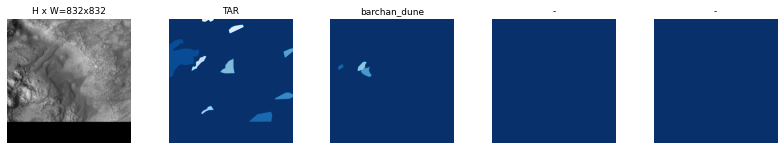

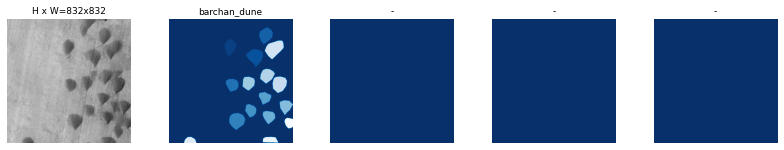

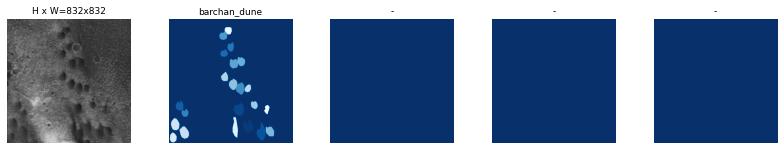

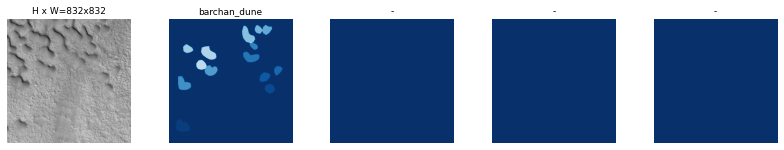

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id, config)
    mask, class_ids = dataset.load_mask(image_id, config)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding boxes

image_id  56 /home/liorr/Mask_RCNN/mrcnn/aeolian_dataset/dataset/train/ckcxn1u53003n3a60k8pncjul.jpg
image                    shape: (832, 832, 3)         min:    0.00000  max:  255.00000  int16
mask                     shape: (832, 832, 28)        min:    0.00000  max:    1.00000  float64
class_ids                shape: (28,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (28, 4)               min:  141.00000  max:  832.00000  int32


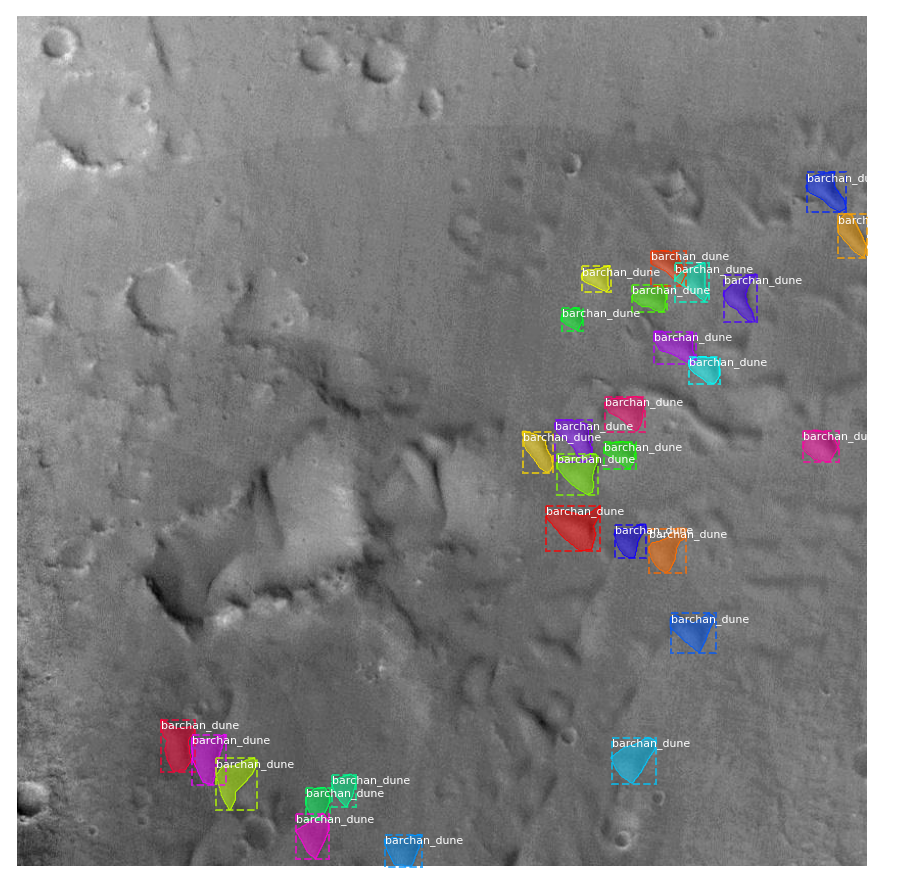

/home/liorr/Mask_RCNN/mrcnn/aeolian_dataset/dataset/train/ckcxn1u53003n3a60k8pncjul.jpg


In [21]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id, config)
mask, class_ids = dataset.load_mask(image_id, config)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

print(dataset.image_reference(image_id))

In [23]:
def isgrayscale(img):
    if len(img.shape) < 3:
        return True
    if img.shape[2]  == 1:
        return True
    
    blue, green, red = img[:,:,0], img[:,:,1], img[:,:,2]

    if np.all(blue == green) and np.all(blue == red):
        return True
    return False


## Resize Images
To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.


image_id:  114 /home/liorr/Mask_RCNN/mrcnn/aeolian_dataset/dataset/train/ckcns5wo70mm10y7gdgvt6p4d.jpg
Original shape:  (832, 832, 3)
image                    shape: (832, 832, 3)         min:    0.00000  max:  255.00000  int16
mask                     shape: (832, 832, 21)        min:    0.00000  max:    1.00000  float64
class_ids                shape: (21,)                 min:    1.00000  max:    2.00000  int32
bbox                     shape: (21, 4)               min:    0.00000  max:  812.00000  int32


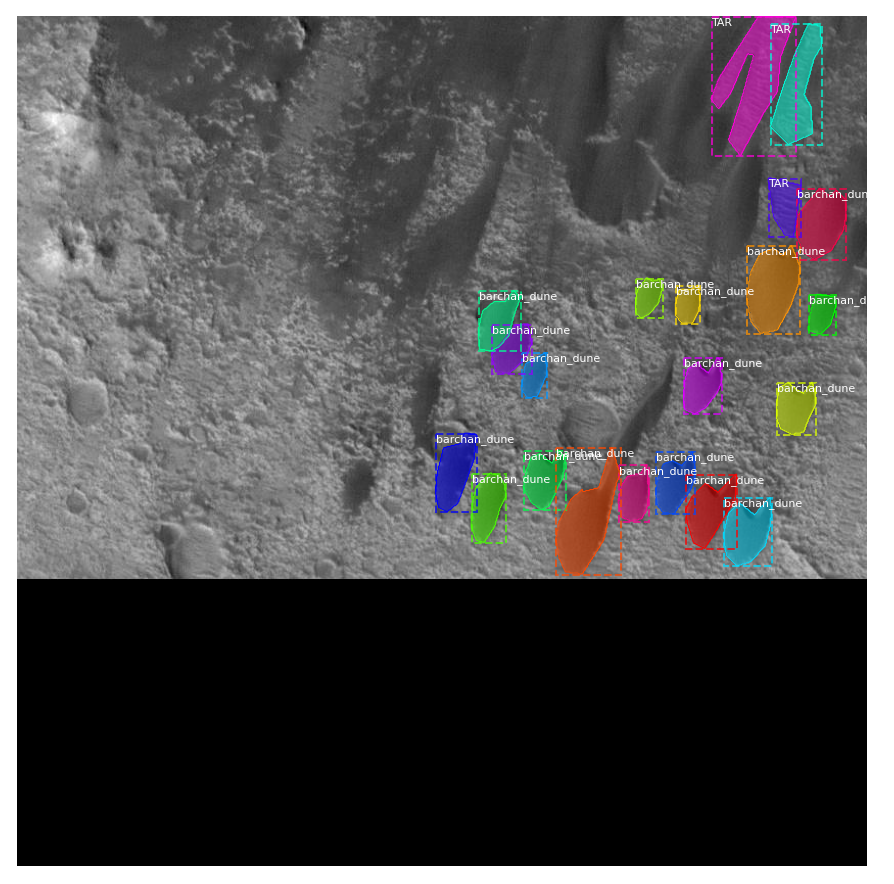

In [25]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id, config)
mask, class_ids = dataset.load_mask(image_id, config)
original_shape = image.shape

# Resize
image, window, scale, padding, crop = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Mini Masks
Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone.

To improve training speed, we optimize masks by:

We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.
To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

image                    shape: (832, 832, 3)         min:    0.00000  max:  255.00000  int16
image_meta               shape: (15,)                 min:    0.00000  max:  832.00000  int64
class_ids                shape: (11,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (11, 4)               min:    0.00000  max:  659.00000  int32
mask                     shape: (832, 832, 11)        min:    0.00000  max:    1.00000  float64


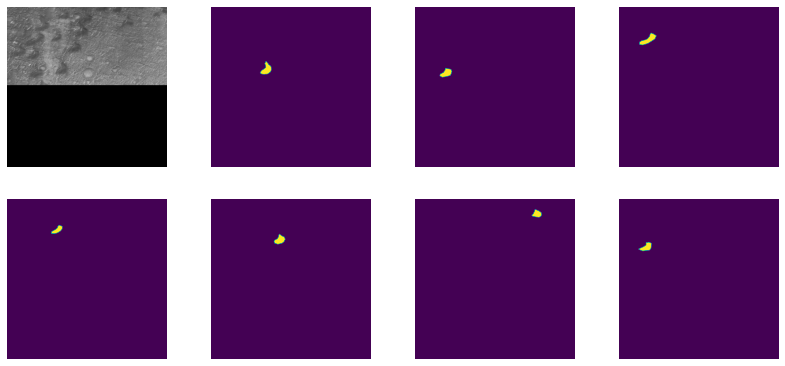

In [32]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])


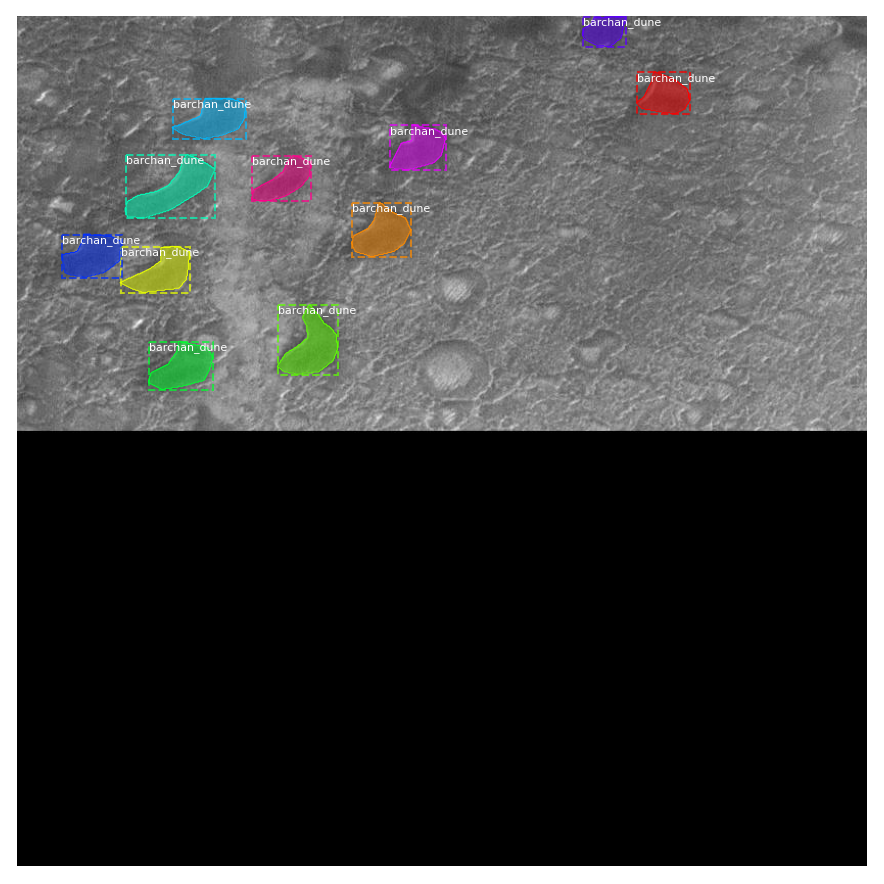

In [33]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 11)          min:    0.00000  max:    1.00000  bool


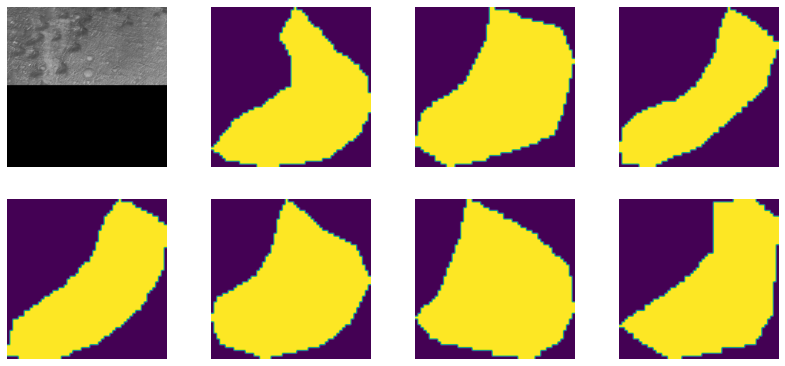

In [35]:
# Add augmentation and mask resizing.
import imgaug

augmentations = iaa.Sequential([
    iaa.Sometimes(0.5, [
        iaa.OneOf( [ 
            iaa.ContrastNormalization((0.1, 0.4)),
            iaa.Invert(p = 1)
        ])
    ]), 
    iaa.Sometimes(0.5, [
        iaa.OneOf( [ 
            imgaug.augmenters.Affine(rotate=45),
            imgaug.augmenters.Affine(rotate=90),
            imgaug.augmenters.Affine(rotate=135),                                    
            imgaug.augmenters.Affine(rotate=180),
            imgaug.augmenters.Affine(rotate=225),                                    
            imgaug.augmenters.Affine(rotate=270),
        ])
    ])    
    ], random_order = True
)

# augmentations = imgaug.augmenters.Sometimes(1,
#                                 imgaug.augmenters.OneOf
#                                 (
#                                 [
#                                 imgaug.augmenters.Affine(rotate=45),
#                                 imgaug.augmenters.Affine(rotate=90),
#                                 imgaug.augmenters.Affine(rotate=135),                                    
#                                 imgaug.augmenters.Affine(rotate=180),
#                                 imgaug.augmenters.Affine(rotate=225),                                    
#                                 imgaug.augmenters.Affine(rotate=270),                                    
#                                 ]
#                             )
#                                 imgaug.augmenters.OneOf
#                                 (
#                                 [
#                                 imgaug.augmenters.Affine(rotate=45),
#                                 imgaug.augmenters.Affine(rotate=90),
#                                 imgaug.augmenters.Affine(rotate=135),                                    
#                                 imgaug.augmenters.Affine(rotate=180),
#                                 imgaug.augmenters.Affine(rotate=225),                                    
#                                 imgaug.augmenters.Affine(rotate=270),                                    
#                                 ]
#                             )
#                         )

image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augmentation=augmentations, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

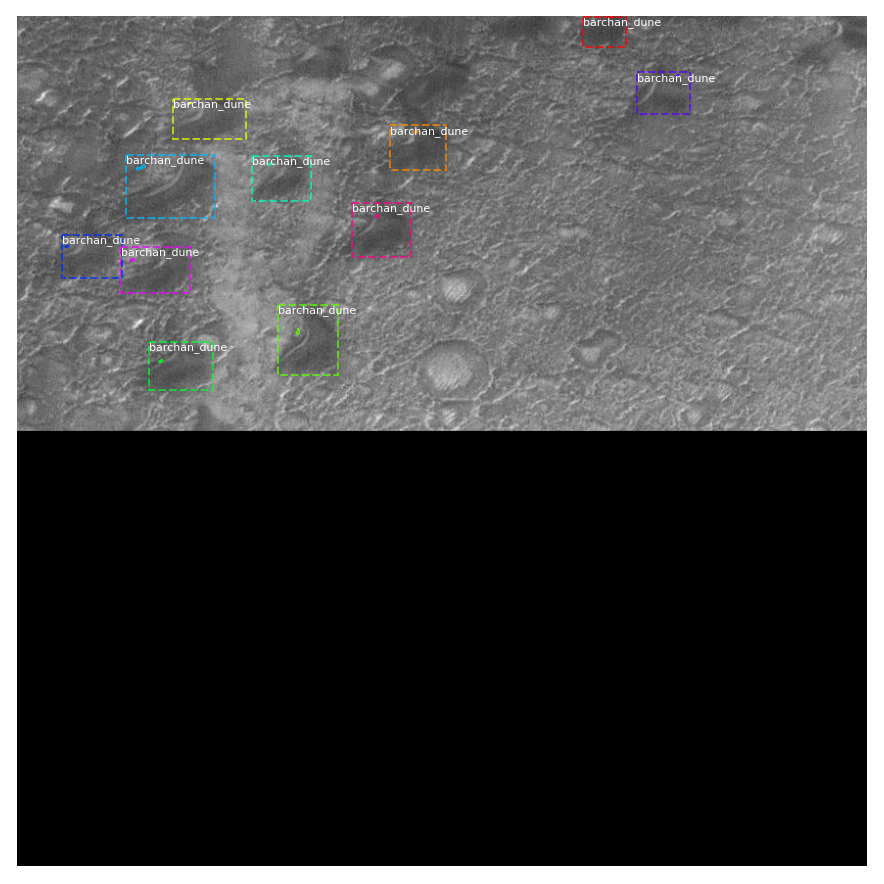

In [37]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors
The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts.

Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row.
For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.
Anchor Stride: In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature meap of the first layer is 256x256, which generates about 200K anchors (2562563). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example.

In this implementation we use an anchor stride of 2, which is different from the paper.

In [55]:
# Generate Anchors
config.BACKBONE_SHAPES = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          config.BACKBONE_SHAPES,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(config.BACKBONE_SHAPES)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = config.BACKBONE_SHAPES[l][0] * config.BACKBONE_SHAPES[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  172887
Scales:  (16, 32, 64, 128, 256)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 129792
Anchors in Level 1: 32448
Anchors in Level 2: 8112
Anchors in Level 3: 2028
Anchors in Level 4: 507


Level 0. Anchors: 129792  Feature map Shape: [208 208]
Level 1. Anchors:  32448  Feature map Shape: [104 104]
Level 2. Anchors:   8112  Feature map Shape: [52 52]
Level 3. Anchors:   2028  Feature map Shape: [26 26]
Level 4. Anchors:    507  Feature map Shape: [13 13]


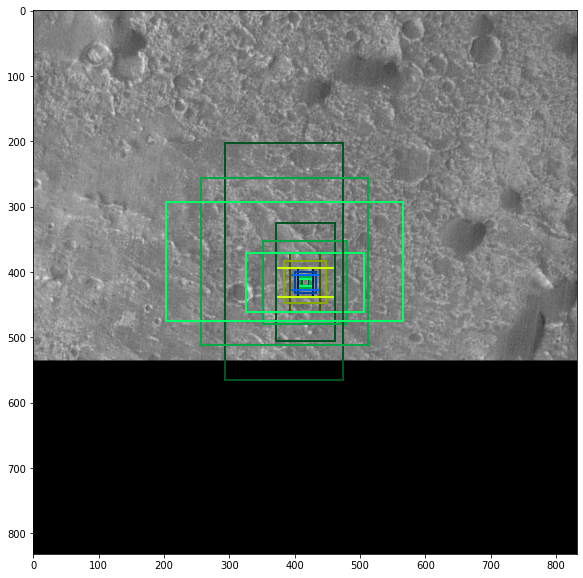

In [56]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(config.BACKBONE_SHAPES)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                config.BACKBONE_SHAPES[level]))
    center_cell = config.BACKBONE_SHAPES[level] // 2
    center_cell_index = (center_cell[0] * config.BACKBONE_SHAPES[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * config.BACKBONE_SHAPES[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)

## Data Generator


In [57]:
# Create data generator
random_rois = 2000

g = modellib.DataGenerator(dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)


# g = modellib.data_generator(
#     dataset, config, shuffle=True, random_rois=random_rois, 
#     batch_size=4,
#     detection_targets=True)

In [58]:
# Uncomment to run the generator through a lot of images
# to catch rare errors
# for i in range(1000):
#     print(i)
#     _, _ = next(g)

In [66]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = image_meta[0][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 200, 4)           min:    0.00000  max:  831.00000  int32
mrcnn_class_ids          shape: (4, 200, 1)           min:    0.00000  max:    2.00000  int32
mrcnn_bbox               shape: (4, 200, 3, 4)        min:   -3.21429  max:    3.42105  float32
mrcnn_mask               shape: (4, 200, 28, 28, 3)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 100)              min:    0.00000  max:    2.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  832.00000  int32
gt_masks                 shape: (4, 56, 56, 100)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 172887, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -2.73983  max:    2.84859  float64
image_id:  12 /home/liorr/Mask_RCNN/mrcnn/aeolian_dataset/dataset/train/ckcw5285r000d3b60cthc4pf8.jpg


anchors                  shape: (172887, 4)           min: -181.01934  max:  949.01934  float64
refined_anchors          shape: (7, 4)                min:  178.00000  max:  503.00000  float32
Positive anchors: 7
Negative anchors: 249
Neutral anchors: 172631
BG                     : 172
barchan_dune           : 28


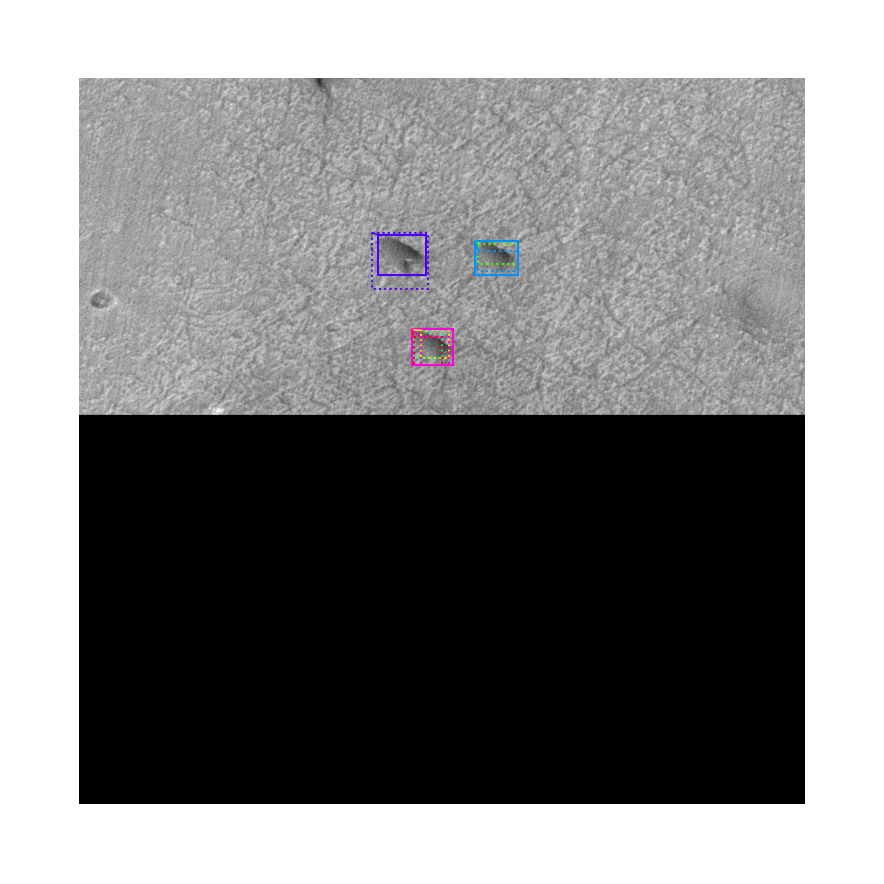

In [67]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

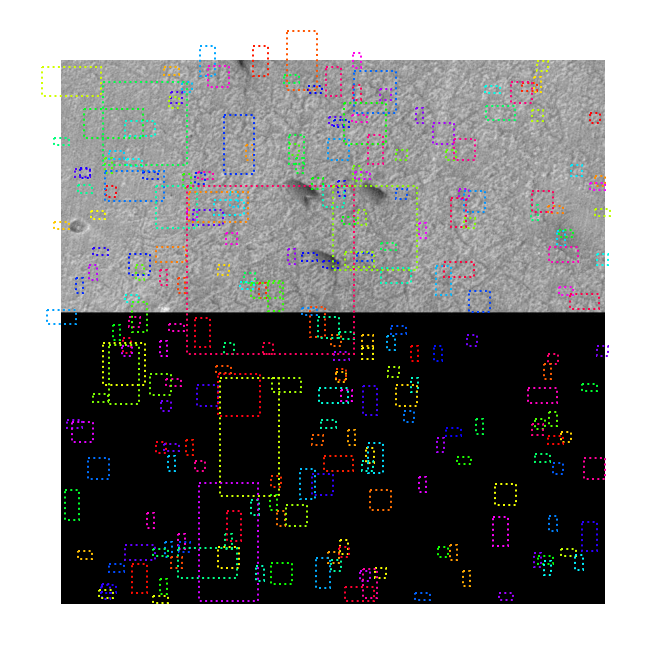

In [68]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

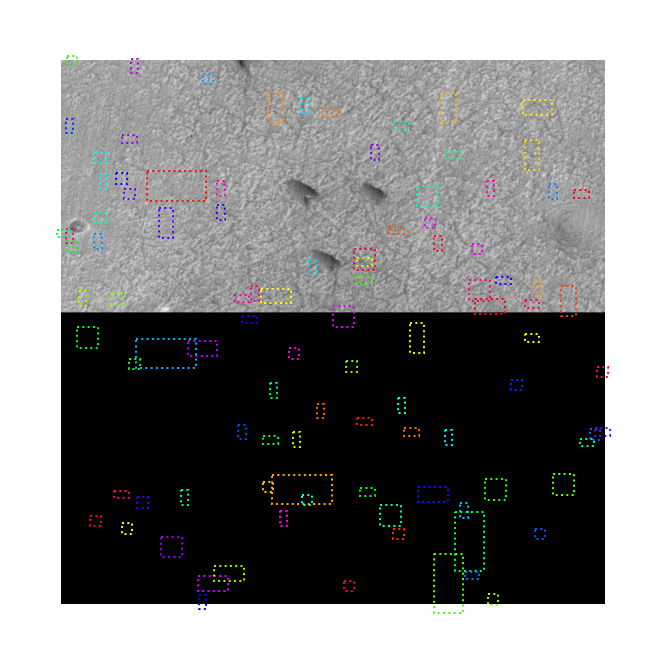

In [69]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

Positive ROIs:  28
Negative ROIs:  172
Positive Ratio: 0.14
Unique ROIs: 200 out of 200


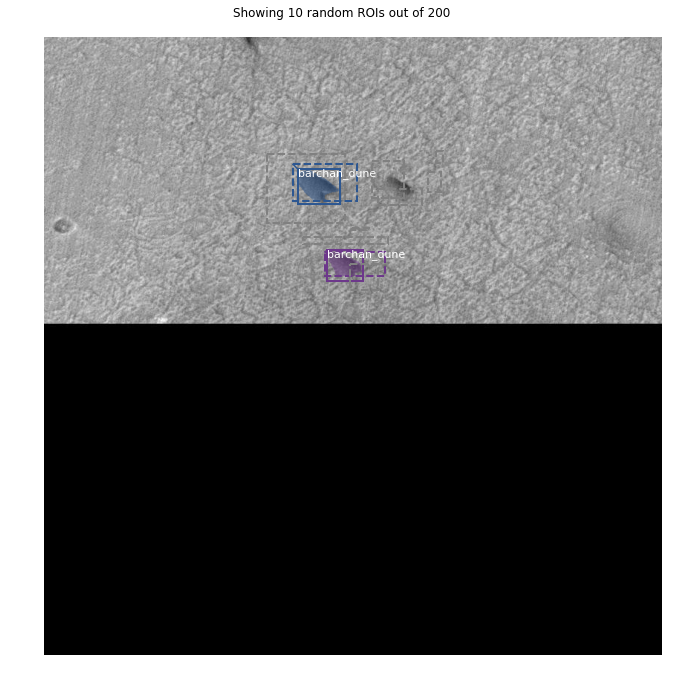

In [70]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

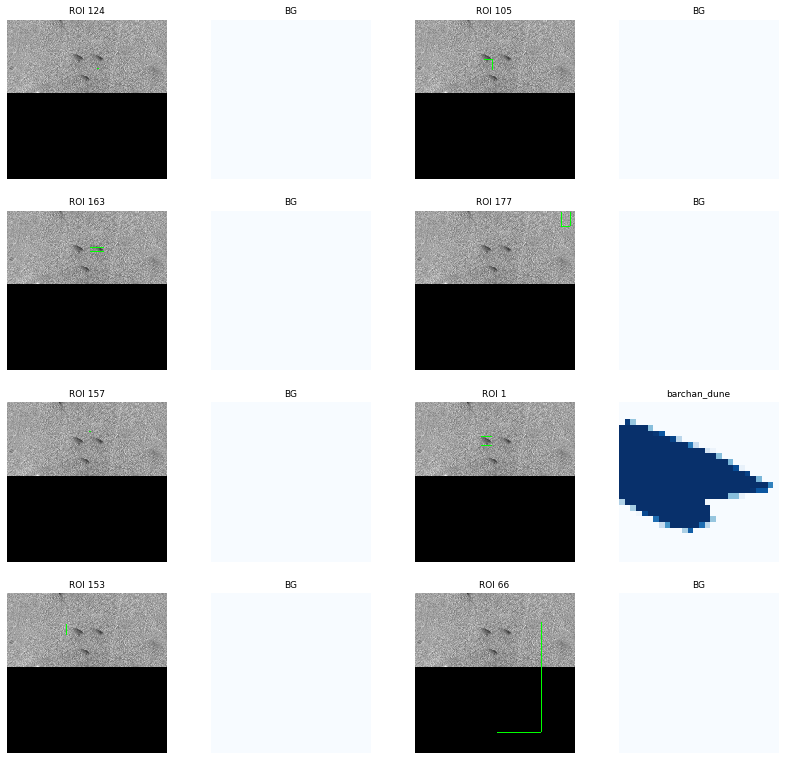

In [71]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [72]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.DataGenerator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
Average percent: 0.33
